# Analysing the Stock Market with Python - Part I

This notebook mainly explains how to import stocks price data from Yahoo Finance, calculate your portfolio performance, and other **interesting** stuff.

Detailed contents:
* download data from yahoo finance using stocknames example ['MSFT', 'AAPL', 'SPY']
* plot normalised graphs, ie, starting at 1 for all
* daily returns ratio = df.pct_change()
* correlations: daily_returns.corr()
* cumulative returns ratio: profit/loss ratio
* Sharpe ratio
* daily portfolio value (DPV) for example allocation: 20% MSFT, 70% AAPL, 10% SPY
* candles chart

In [1]:
# #libraries prerequisite
# !pip install yfinance
# !pip install mplfinance
# !pip install plotly --user
# !pip install seaborn
# !pip install statsmodels

In [3]:
import yfinance
# from yahoofinancials import YahooFinancials
import mplfinance as mpf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from plotly import express as px
import datetime as dt
import os

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

--------------------------------------------------------------
# *Download Data from* <font color='purple'>Yahoo!</font>
Option 1- Using `yf.download` (Recommended)<br>
Option 2- Using `yfinance.Ticker(['list of stock names']).history('args')`<br>
Option 3- Using `pandas_data_reader`<br>

[List of SP500 Companies](https://www.liberatedstocktrader.com/sp-500-companies/)

*Define stock names, Start date, End date, and interval*

In [4]:
import yfinance
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.3f}'.format

stocknames = ['MSFT', 'AAPL', 'SPY']    #ticker
startdate = '2019-01-01'
# enddate =   dt.datetime.now().date()    #change to current day date if required
enddate = '2022-12-31'
interval = '1d'

downloading data using Using yf.download (Recommended)

In [7]:
for stock in stocknames:
    df = yfinance.download(stock, interval=interval, period='max')
    df.to_csv('stocks_data\\{}.csv'.format(stock))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


downloading data using Using yfinance.Ticker(['list of stock names']).history('args')

In [173]:
# for stock in stocknames:
#     df = yfinance.Ticker(stock).history(start = startdate, end = enddate, interval=interval, auto_adjust=True)
#     # yfinance.Ticker(stocknames).history(period='max', interval=interval, auto_adjust=True)
#     df.to_csv('{}.csv'.format(stock))

downloading data using Using pandas_datareader

In [174]:
# from pandas_datareader import data
# for stock in stocknames:
#     df = data.DataReader(stock, 'yahoo', startdate, enddate)
#     df.to_csv('{}.csv'.format(stock))

In [175]:
# from pandas_datareader import data
# data.get_data_yahoo(stocknames, start=startdate, end=enddate)

--------------------------------------------------------------

In [9]:
def appending(cols=[], startdate='', enddate=''):
    '''append stocks data into one file and then select the 'Adj Close' column'''
    dates = pd.date_range(start=startdate, end=enddate)
    df = pd.DataFrame(index=dates)
    for stock in stocknames:
        df_stock = pd.read_csv('stocks_data\\{}.csv'.format(stock), index_col='Date', parse_dates=True, usecols=cols, na_values=['NaN'])
        df_stock = df_stock.rename(columns = {'Adj Close': stock})
        df = df.join(df_stock)
        df = df.loc[dates]
    df.index.names = ['Date']
    df = df.dropna()    #there are other ways to handle missing values. For simplicity, drop them for now
    return df

df = appending(['Date', 'Adj Close'], startdate, enddate)
print(df)

              MSFT    AAPL     SPY
Date                              
2019-01-02  96.422  37.994 232.309
2019-01-03  92.875  34.210 226.765
2019-01-04  97.194  35.670 234.361
2019-01-07  97.318  35.591 236.209
2019-01-08  98.024  36.269 238.428
...            ...     ...     ...
2022-12-23 237.614 131.477 380.042
2022-12-27 235.852 129.652 378.544
2022-12-28 233.434 125.674 373.839
2022-12-29 239.883 129.234 380.569
2022-12-30 238.699 129.553 379.566

[1008 rows x 3 columns]


### *Global Statistics:*

In [33]:
df_desc = df.describe().T
df_desc[['count', 'mean', 'std', 'min', '50%', 'max']]

,count,mean,std,min,50%,max
MSFT,"1,008.000",213.035,65.826,93.078,217.908,339.076
AAPL,"1,008.000",109.473,43.402,34.257,122.187,180.684
SPY,"1,008.000",349.660,66.218,212.973,356.991,468.296


### A Quick look at the prices

In [6]:
from plotly import express as px

px.line(data_frame=df, title='Tickers Adj. Close Prices', width=1000, height=500)

--------------------------------------------------------------
We need to observe the `relative stock movement`, i.e. how much the stock went up or down compared to the other stocks. Therefore we need to **`Normalize`** the stock prices to start with $1.

To do this we will ***divide the prices of each column by Day-One-Price***.<br>
$$Norm = df / df.iloc[0,:]$$

In [31]:
df.head()

,MSFT,AAPL,SPY
Date,,,
2019-01-02,96.633,38.047,233.172
2019-01-03,93.078,34.257,227.608
2019-01-04,97.407,35.720,235.231
2019-01-07,97.531,35.640,237.086
2019-01-08,98.238,36.320,239.314


In [10]:
norm = df / df.iloc[0,:]
norm.head()

,MSFT,AAPL,SPY
Date,,,
2019-01-02,1.000,1.000,1.000
2019-01-03,0.963,0.900,0.976
2019-01-04,1.008,0.939,1.009
2019-01-07,1.009,0.937,1.017
2019-01-08,1.017,0.955,1.026


Plot the normalized graphs using plotly

In [7]:
fig = px.line(norm, x=norm.index, y=['MSFT', 'AAPL', 'SPY'])
fig.update_layout(title='Stock movement observation by normalizing Adj close prices, (Daily Cumulative Return)',
                  xaxis_title='Date',
                  yaxis_title='Normalized price')
fig.show()

Plot the normalized graphs using pandas dataframe plot function (same output)

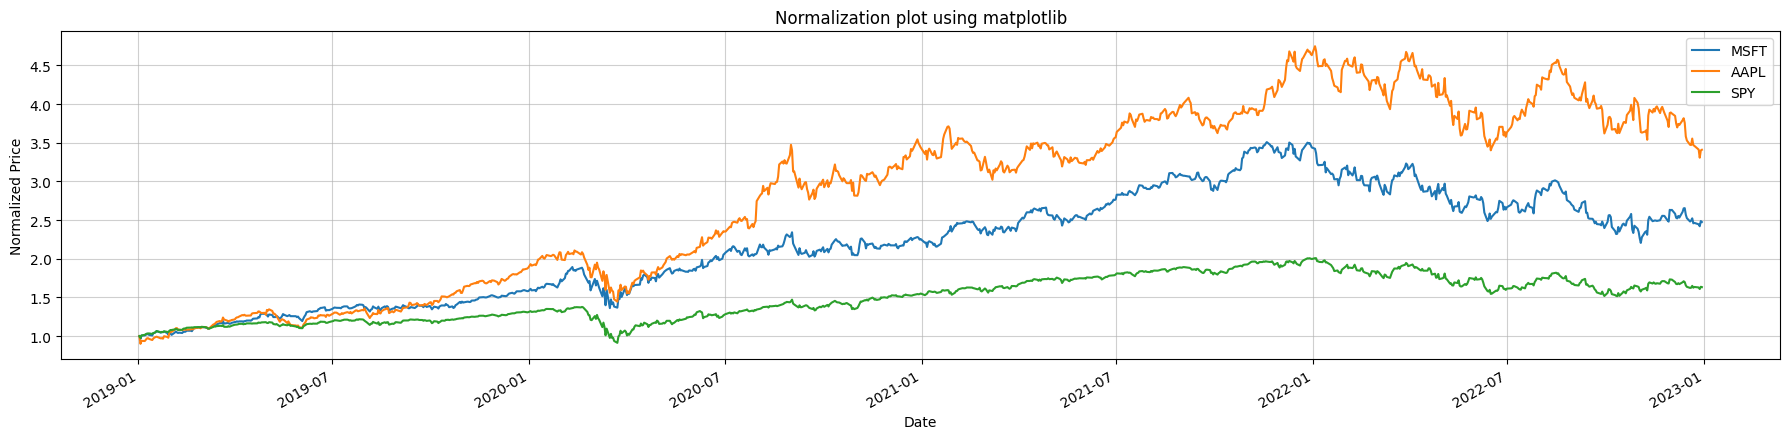

In [18]:
from matplotlib import pyplot as plt

norm.plot(figsize=(18, 4.5))
plt.grid(alpha=0.6)
plt.title('Normalization plot using matplotlib')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.tight_layout()

### *Rolling Statistics*

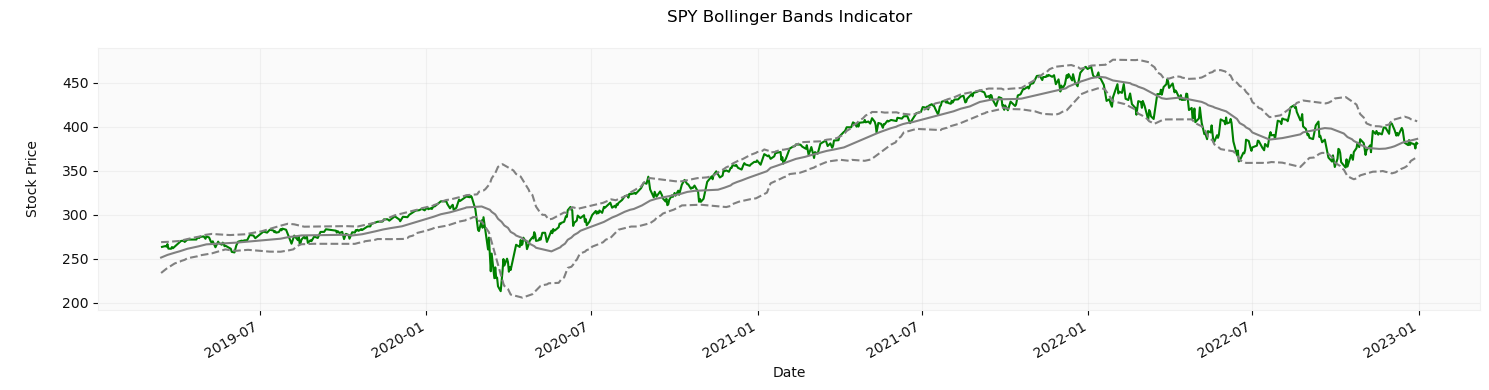

In [269]:
rollingmean = df.SPY.rolling(50).mean()
rollingstd = df.SPY.rolling(50).std()
lowerbound = rollingmean - (2 * rollingstd)
upperbound = rollingmean + (2 * rollingstd)
fig, ax = plt.subplots(figsize=(15,4))
df.iloc[50:]['SPY'].plot(ax=ax, color='green')
ax.set_title('SPY Bollinger Bands Indicator\n')
ax.set_xlabel('Date')
ax.set_ylabel('\nStock Price\n')
rollingmean.plot(ax=ax, linestyle='-', color='grey')
lowerbound.plot(ax=ax, linestyle='--', color='grey')
upperbound.plot(ax=ax, linestyle='--', color='grey')
plt.grid(alpha=0.25)
plt.tight_layout()

---------------------------------------------
# Metrics
> * Daily Returns Ratio
> * Cummulative Returns Ratio
> * Sharpe Ratio

### <font color='orange'>Daily Returns Ratio:</font> how much did the price go up or down on a particular day 
$$Daily Returns (t) = (price[t] / price[t-1]) - 1$$

To calculate the percentage change for each day

In [35]:
daily_returns = (df / df.shift(1)) -1
daily_returns.iloc[0, :] = 0
daily_returns.head()

,MSFT,AAPL,SPY
Date,,,
2019-01-02,0.000,0.000,0.000
2019-01-03,-0.037,-0.100,-0.024
2019-01-04,0.047,0.043,0.033
2019-01-07,0.001,-0.002,0.008
2019-01-08,0.007,0.019,0.009


You can get the same result by using `pct_change` function (same output)

In [20]:
daily_returns = df.pct_change()
daily_returns.iloc[0, :] = 0
print(daily_returns)

             MSFT   AAPL    SPY
Date                           
2019-01-02  0.000  0.000  0.000
2019-01-03 -0.037 -0.100 -0.024
2019-01-04  0.047  0.043  0.033
2019-01-07  0.001 -0.002  0.008
2019-01-08  0.007  0.019  0.009
...           ...    ...    ...
2022-12-23  0.002 -0.003  0.006
2022-12-27 -0.007 -0.014 -0.004
2022-12-28 -0.010 -0.031 -0.012
2022-12-29  0.028  0.028  0.018
2022-12-30 -0.005  0.002 -0.003

[1008 rows x 3 columns]


In [39]:
#Daily Returns Ratio global statistics
daily_returns.describe().T

,count,mean,std,min,25%,50%,75%,max
MSFT,"1,008.000",0.001,0.020,-0.147,-0.009,0.001,0.011,0.142
AAPL,"1,008.000",0.001,0.022,-0.129,-0.009,0.001,0.013,0.120
SPY,"1,008.000",0.001,0.014,-0.109,-0.005,0.001,0.007,0.091


*Annualized Returns*

In [21]:
annualized_returns = df.pct_change().mean().apply(lambda x: x*252)
print(annualized_returns)
print('stock | daily_returns_mean | annualized_returns')
for stock in stocknames:
    print(stock, '|', daily_returns[stock].mean(), '|', round(daily_returns[stock].mean()*252, 3))

MSFT   0.277
AAPL   0.367
SPY    0.148
dtype: float64
stock | daily_returns_mean | annualized_returns
MSFT | 0.0010989278328134822 | 0.277
AAPL | 0.0014545251409185354 | 0.367
SPY | 0.0005883689363459856 | 0.148


*Annualized Volatility*

In [22]:
annualized_volatility = df.pct_change().std().apply(lambda x: x*np.sqrt(252))
print(annualized_volatility)
print('stock | daily_returns_std | annualized_volatility')
for stock in stocknames:
    print(stock, '|', daily_returns[stock].std(), '|', round(daily_returns[stock].std()*np.sqrt(252), 3))

MSFT   0.317
AAPL   0.346
SPY    0.225
dtype: float64
stock | daily_returns_std | annualized_volatility
MSFT | 0.019958074853807135 | 0.317
AAPL | 0.021767868033377158 | 0.346
SPY | 0.014190844032870535 | 0.225


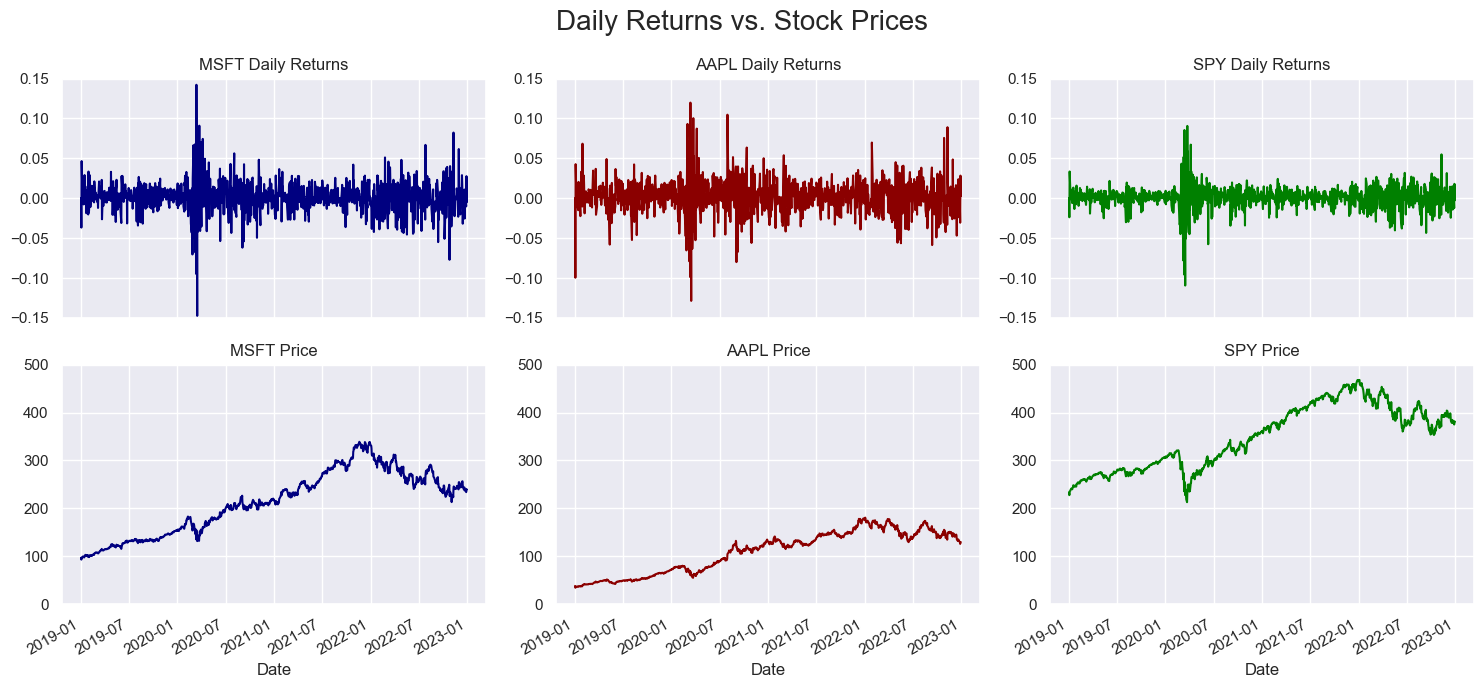

In [45]:
stocknames = ['MSFT', 'AAPL', 'SPY']
colorlist = ['navy', 'darkred', 'green']
fig, ax = plt.subplots(2,3, figsize=(15,7), sharex=True)

for i, stock in enumerate(stocknames):
    daily_returns[stock].plot(ax=ax[0][i], color=colorlist[i])
    ax[0][i].set_title(stock + ' Daily Returns')
    ax[0][i].set_ylim(-0.15, 0.15)

    df[stock].plot(ax=ax[1][i], color=colorlist[i])
    ax[1][i].set_title(stock + ' Price')
    ax[1][i].set_ylim(0, 500)

fig.suptitle('Daily Returns vs Stock Prices', fontsize=20)
plt.tight_layout()

*Daily return statistics*<br>
1- **The Mean** - use this to calculate Annualized Returns <br>
2- **Standard Deviation** - use this to calculate Annualized Volatility <br>
3- **Kurtosis:** tell us about the `tails of the normal distribution`. the measure of Kurtosis tells us how much `different` our histogram is from that traditional normal distribution.<br><br>
<font color='skyblue'>Types of Kurtosis:</font> <br>

> **Fat tails (value is positive)**: means that there are occasional and more frequent that would happen if we had a regular Gaussin distribution. There are frequently large excursions more frequently than if this was a normal distribution. (More occurrences out in the tails than would be expected if it were a normal distribution).<br><br>

> **Skinny tails (value is negative)**: (Many fewer occurrences out on the tails than would be expected if it were a normal distribution).<br><br>

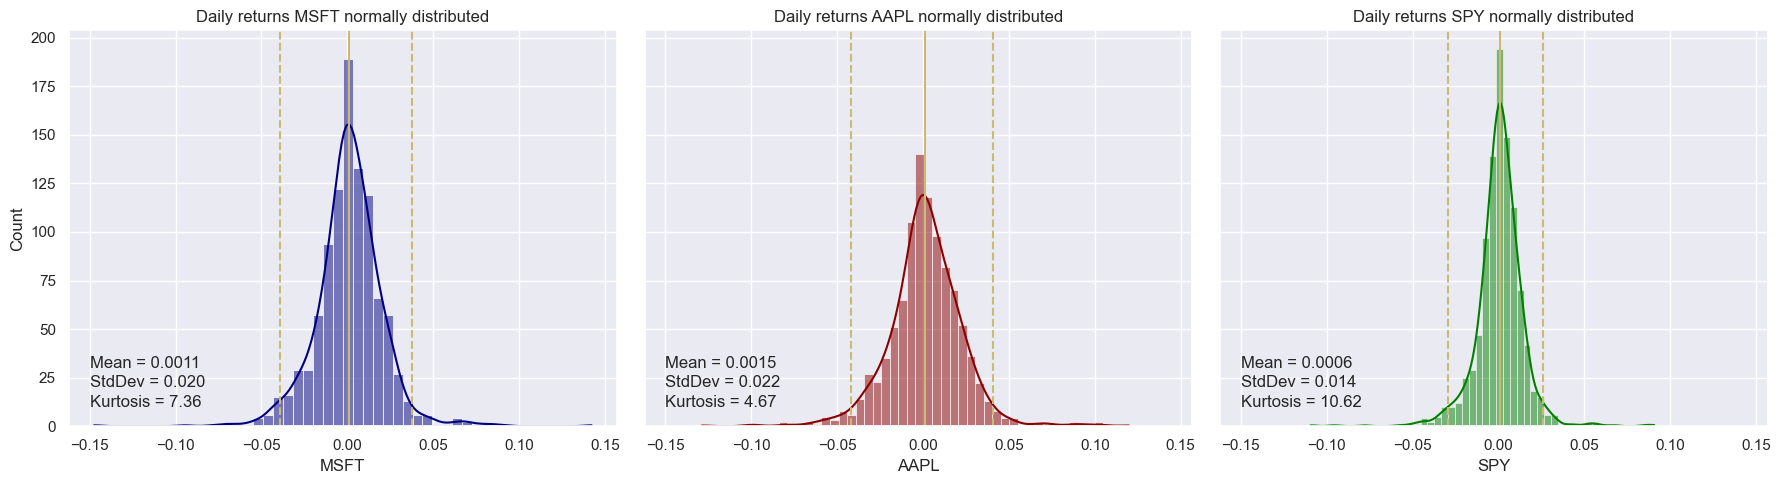

In [101]:
stocknames = ['MSFT', 'AAPL', 'SPY']
colorlist = ['navy', 'darkred', 'green']
fig, ax = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=True)

for i, stock in enumerate(stocknames):
    sns.histplot(daily_returns[stock], bins=50, kde=True, color=colorlist[i], ax=ax[i])
    ax[i].set_title('Daily returns ' + stock + ' normally distributed')
    ax[i].axvline(daily_returns[stock].mean(), c='y')
    ax[i].axvline(np.percentile(daily_returns[stock],97.5), linestyle='--', c='y')
    ax[i].axvline(np.percentile(daily_returns[stock],2.5), linestyle='--', c='y')
    ax[i].text(-0.15, 30, 'Mean = {:.4f}'.format(daily_returns[stock].mean()))
    ax[i].text(-0.15, 20, 'StdDev = {:.3f}'.format(daily_returns[stock].std()))
    ax[i].text(-0.15, 10, 'Kurtosis = {:.2f}'.format(daily_returns[stock].kurtosis()))

plt.tight_layout()

Based on Kurtosis results: There are more occurrences in the tails than that of a standard normal distribution.

---------------------------------------------------------------------

##### We are considering two general properties indicated by the histogram for each stock: 1.**Return** and 2.**Volatility (or risk)**.

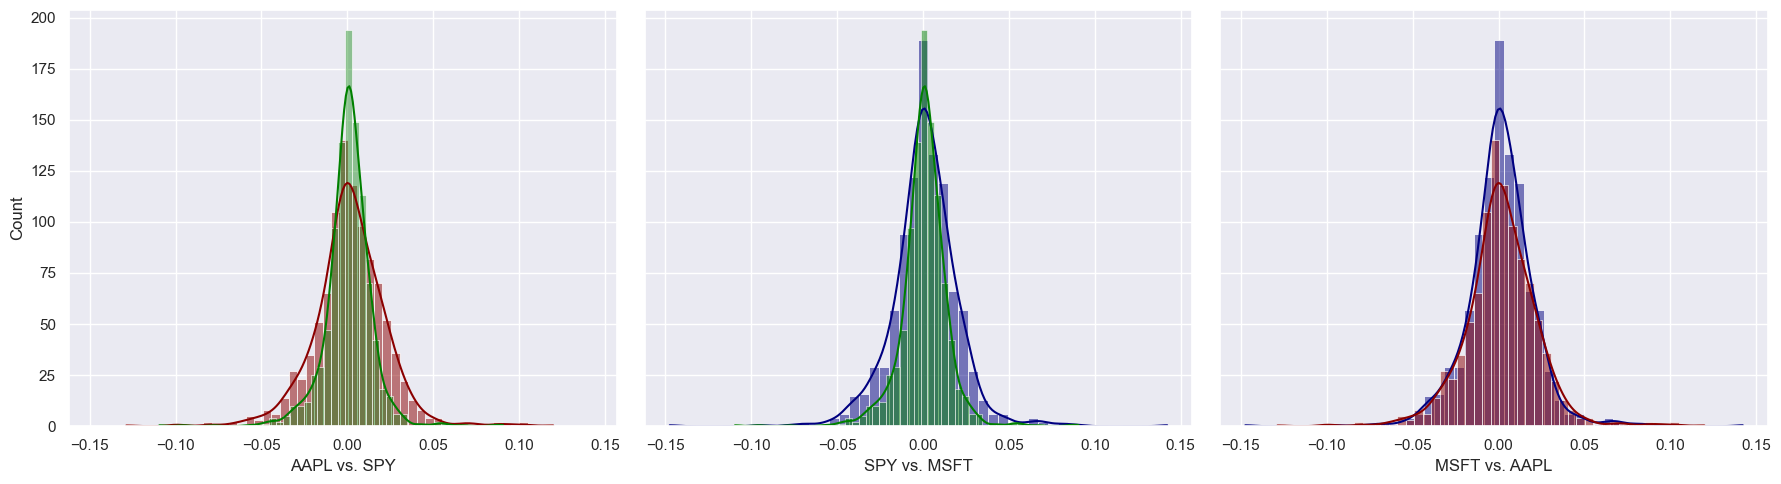

In [104]:
fig, ax = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=True)
sns.histplot(daily_returns.AAPL, bins=50, color='darkred', ax=ax[0], kde=True)
sns.histplot(daily_returns.SPY, bins=50, color='green', ax=ax[0], kde=True, alpha=0.4)
ax[0].set_xlabel('AAPL vs. SPY')
sns.histplot(daily_returns.MSFT, bins=50, color='navy', ax=ax[1], kde=True)
sns.histplot(daily_returns.SPY,  bins=50, color='green', ax=ax[1], kde=True)
ax[1].set_xlabel('SPY vs. MSFT')
sns.histplot(daily_returns.MSFT, bins=50, color='navy', ax=ax[2], kde=True)
sns.histplot(daily_returns.AAPL, bins=50, color='darkred', ax=ax[2], kde=True, alpha=0.5)
ax[2].set_xlabel('MSFT vs. AAPL')
plt.tight_layout()

In [88]:
df_ret_vol = pd.concat([annualized_returns.to_frame('Annualized Returns'), annualized_volatility.to_frame('Annualized Volatility')], axis=1)
print(df_ret_vol)

      Annualized Returns  Annualized Volatility
MSFT               0.277                  0.317
AAPL               0.367                  0.346
SPY                0.148                  0.225


For returns comparison, refer to Normalization plot. For volatility comparison, refer to the above plot (fat/wider means higher volatility)

1. `APPL` has higher return and higher volatility than `SPY` <br>
2. `SPY` has lower return and lower volatility than `MSFT` <br>
3. `MSFT` has lower return and slightly lower volatility than `AAPL`

---------------------------------------------

A portfolio is a collection of a number of stocks with different allocations. Before building a portfolio, we need the understand the concept of correlations. 

Correlation is a statistical measure that describes the extent to which two variables are related. In the context of investing, correlation refers to the relationship between the prices of two or more assets.

## Correlations

In [114]:
daily_returns.corr()

,MSFT,AAPL,SPY
MSFT,1.000,0.787,0.853
AAPL,0.787,1.000,0.812
SPY,0.853,0.812,1.000


[[1.         0.81189211]
 [0.81189211 1.        ]]
[[1.         0.78731658]
 [0.78731658 1.        ]]
[[1.         0.85290528]
 [0.85290528 1.        ]]


<Axes: >

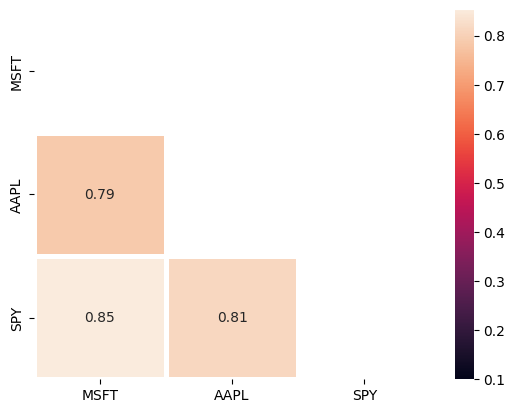

In [24]:
print(np.corrcoef(daily_returns.SPY, daily_returns.AAPL))
print(np.corrcoef(daily_returns.MSFT, daily_returns.AAPL))
print(np.corrcoef(daily_returns.SPY, daily_returns.MSFT))

import seaborn as sns

#take the bottom triangle since it repeats itself 
mask = np.zeros_like(daily_returns.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(daily_returns.corr(), annot=True, vmin=0.1, mask=mask, linewidths=2.5)

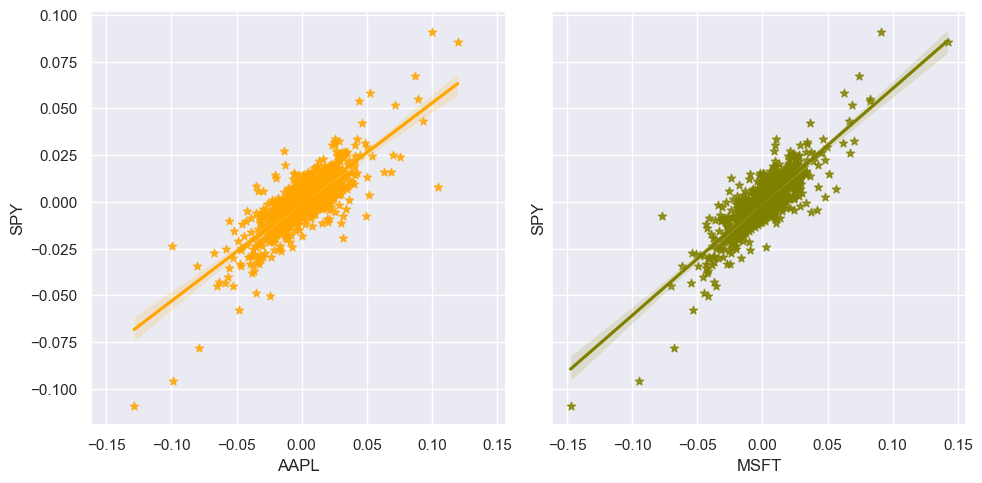

In [199]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
sns.regplot(data=daily_returns, x=daily_returns.AAPL, y=daily_returns.SPY ,scatter=True, marker='*', ax=ax[0], color='orange')
sns.regplot(data=daily_returns, x=daily_returns.MSFT, y=daily_returns.SPY ,scatter=True, marker='*', ax=ax[1], color='olive')
plt.tight_layout()

*Correlation Coefficient and P-value using SciPy:*

In [206]:
coeff, pval = stats.pearsonr(daily_returns.AAPL, daily_returns.SPY)
print('CorrCoeff AAPL/SPY= {:,.0f}'.format(coeff), 'Pval={}'.format(pval))
coeff, pval = stats.pearsonr(daily_returns.MSFT, daily_returns.SPY)
print('CorrCoeff MSFT/SPY= {:,.0f}'.format(coeff), 'Pval={}'.format(pval))

CorrCoeff AAPL/SPY= 1 Pval=2.2809115466164974e-237
CorrCoeff MSFT/SPY= 1 Pval=3.1693867871413373e-286


β (Beta = Slop): is how reactive is the market to the stock.<br>
α (Alpha = Intercept): is how well the market performs with respect of stock

$$ŷ = βx + α$$
$$ŷ = Beta * x + Alpha$$
$$ŷ = Slop * x + Intercept$$

*Correlation Coefficient and Pvalue using Numpy:*

In [203]:
beta_SPY_AAPL, alpha_SPY_AAPL = np.polyfit(daily_returns.AAPL, daily_returns.SPY,1)
print('beta AAPL/SPY= {}'.format(beta_SPY_AAPL), 'alpha AAPL/SPY= {}'.format(alpha_SPY_AAPL))
beta_SPY_MSFT, alpha_SPY_MSFT = np.polyfit(daily_returns.MSFT, daily_returns.SPY,1)
print('beta MSFT/SPY= {}'.format(beta_SPY_MSFT), 'alpha MSFT/SPY= {}'.format(alpha_SPY_MSFT))
# daily_returns.plot(kind='scatter', x= 'AAPL', y='SPY')
# plt.plot(daily_returns.AAPL, beta_SPY * daily_returns.AAPL + alpha_SPY, '-', c='r');

beta AAPL/SPY= 0.5292862955849211 alpha AAPL/SPY= -0.00018149128732592592
beta MSFT/SPY= 0.6064435509156556 alpha MSFT/SPY= -7.806876078546602e-05


When AAPL price goes up 1%, SPY goes up by 0.53%<br>
When MSFT price goes up 1%, SPY goes up by 0.60%

In [207]:
slope, intercept, r, p, std_err = stats.linregress(daily_returns.AAPL, daily_returns.SPY)
print('AAPL/SPY\n','beta (Slope) = ', slope, '\nalpha (Intercept) = ', intercept, '\nCorrCoeff = ', r, '\nPvalue = ', p)
print('-' * 50)
slope, intercept, r, p, std_err = stats.linregress(daily_returns.MSFT, daily_returns.SPY)
print('MSFT/SPY\n','beta (Slope) = ', slope, '\nalpha (Intercept) = ', intercept, '\nCorrCoeff = ', r, '\nPvalue = ', p)

AAPL/SPY
 beta (Slope) =  0.5292862955849214 
alpha (Intercept) =  -0.00018149128732592172 
CorrCoeff =  0.8118921050418351 
Pvalue =  2.2809115466171775e-237
--------------------------------------------------
MSFT/SPY
 beta (Slope) =  0.6064435509156557 
alpha (Intercept) =  -7.806876078546863e-05 
CorrCoeff =  0.8529052786252741 
Pvalue =  3.1693867871407764e-286


*Correlation Coefficient, Pvalue, and Beta using Stats model (Simple Linear Regression):*

In [208]:
# !pip install statsmodels 
import statsmodels.api as sm

ml = daily_returns.copy()
ml['intercept'] = 1
lm = sm.OLS(ml.SPY, ml[['intercept', 'AAPL']])
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     1946.
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          2.28e-237
Time:                        12:13:56   Log-Likelihood:                 3401.9
No. Observations:                1008   AIC:                            -6800.
Df Residuals:                    1006   BIC:                            -6790.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.000     -0.694      0.488      -0.001       0.000
AAPL           0.5293      0.012     44.109      0.000       0.506       0.553
==============================================================================
Omnibus:                      159.251   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              996.545
Skew:                          -0.552   Prob(JB):                    4.01e-217
Kurtosis:                       7.744   Cond. No.                         46.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- When `AAPL` price goes up 1%, `SPY` goes up by 0.53%<br>
- 65.9% of the variability in `SPY` price can be explained by `AAPL` price.

In [209]:
ml = daily_returns.copy()
ml['intercept'] = 1
lm = sm.OLS(ml.SPY, ml[['intercept', 'MSFT']])
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SPY   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     2685.
Date:                Tue, 11 Apr 2023   Prob (F-statistic):          3.17e-286
Time:                        12:16:41   Log-Likelihood:                 3514.6
No. Observations:                1008   AIC:                            -7025.
Df Residuals:                    1006   BIC:                            -7015.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.807e-05      0.000     -0.334      0.739      -0.001       0.000
MSFT           0.6064      0.012     51.817      0.000       0.583       0.629
==============================================================================
Omnibus:                       97.724   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              582.271
Skew:                          -0.177   Prob(JB):                    3.64e-127
Kurtosis:                       6.706   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- When `MSFT` price goes up 1%, `SPY` goes up by 0.60%<br>
- 72.7% of the variability in `SPY` price can be explained by `MSFT` price.

------------------------------------------

### <font color='orange'>Cumulative Return Ratio:</font> is the **Profit/Loss** ratio of the stock on a particular period.
**$$ CR (t) = (price[t] / price[0]) - 1$$**
### <center>or</center>
**$$ CR (t) = (price[t] - price[0]) / price[0]$$**

In [18]:
print('Cumulative return of MSFT is: {:.0f} %'.format(((df.iloc[-1]['MSFT'] / df.iloc[0]['MSFT']) - 1) * 100))
print('Cumulative return of AAPL is: {:.0f} %'.format(((df.iloc[-1]['AAPL'] / df.iloc[0]['AAPL']) - 1) * 100))
print('Cumulative return of SPY is: {:.0f} %'.format(((df.iloc[-1]['SPY'] / df.iloc[0]['SPY']) - 1) * 100))

Cumulative return of MSFT is: 148 %
Cumulative return of AAPL is: 241 %
Cumulative return of SPY is: 63 %


`MSFT` stock price increased by 148% during the period while `AAPL` stock price increased 241%.<br> 
During the same period the `SPY` increased  by 63%.<br>

---------------------------------------------
### <font color='orange'>Daily Portfolio Value (DPV):</font> Calculating overall value of a portfolio Day by Day
*Given:*<br>
    - **start value (start_val):** Portfolio Value (the amount of investment)<br>
    - **start date and end date**<br>
    - **allocations (allocs):** allocating the portfolio value on the stocks<br>
    - **Position value (pos_val):** at each day, that's how much that position is worth<br>
    - **Portfolio value (portfolio_daily_returns):** reflects the value each day for our total portfolio
* normailze the prices = $prices / prices[0]$
* allocs = norm * allocations
* pos_val = allocs * start_value
* portfolio_daily_returns = pos_val.sum(axis=1)<br>

*Portfolio Statistics*
* Daily return of portfolio
* Mean and StdDev

*Portfolio Performance Metrics*
* Portfolio Values
* Annualized Returns
* Annualized Volatility
* Sharpe Ratio

# Portfolio 1 vs Portfolio 2

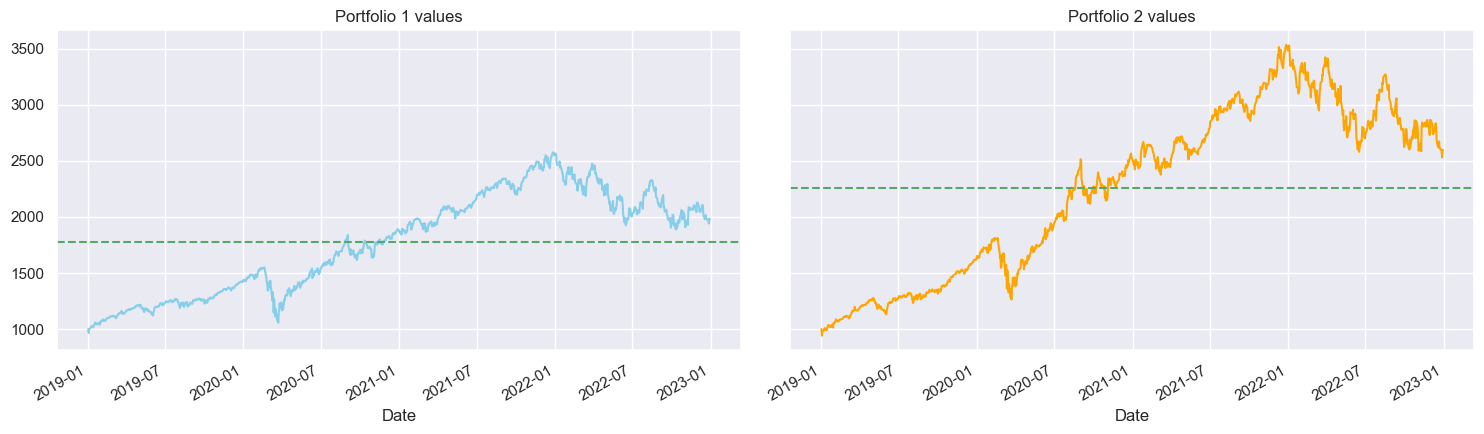

In [27]:
def portval (allocations = [], start_value = 0):
    '''to get daily portfolio value based on allocation'''
    allocs = norm.copy() * allocations
    pos_val = allocs * start_value
    port_val = pos_val.sum(axis=1)
    return port_val

fig, ax = plt.subplots(1, 2, figsize=(15, 4.5), sharex=True, sharey=True)

#assume our start value = $1000
#baseline allocation: 20% MSFT, 10% APPL, 70% SPY
port_val1 = portval([0.2, 0.1, 0.7], 1000)
port_val1.plot(ax=ax[0], color='skyblue')
ax[0].axhline(np.mean(port_val1), linestyle='--', c='g')
ax[0].set_title('Portfolio 1 values')

#new allocation: 30% MSFT, 40% AAPL, 30% SPY
port_val2 = portval([0.3, 0.4, 0.3], 1000)
port_val2.plot(ax=ax[1], color='orange')
ax[1].axhline(np.mean(port_val2), linestyle='--', c='g')
ax[1].set_title('Portfolio 2 values')
plt.tight_layout()

*Portfolio Values*

In [28]:
print('Portfolio 1 Value:  $', round(port_val1[-1], 2))
print('Portfolio 2 Value:  $', round(port_val2[-1], 2))

Portfolio 1 Value:  $ 1979.81
Portfolio 2 Value:  $ 2596.75


*Cumulative Return Ratio of DPV*

In [38]:
cum_return1 = ((port_val1.iloc[-1] / port_val1.iloc[0]) -1) * 100 
print('Cumulative return of Portfolio 1 is {:.1f} %'.format(cum_return1))
cum_return2 = ((port_val2.iloc[-1] / port_val2.iloc[0]) -1) * 100 
print('Cumulative return of Portfolio 2 is {:.1f} %'.format(cum_return2))

Cumulative return of Portfolio 1 is 98.0 %
Cumulative return of Portfolio 2 is 159.7 %


*Mean and StdDev of DPV (Daily Portfolio Value)*

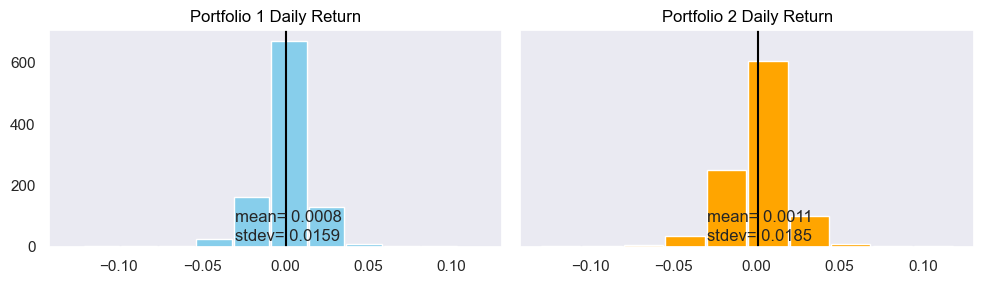

In [40]:
portfolio_daily_returns1 = port_val1.pct_change()
portfolio_daily_returns1.iloc[0] = 0

portfolio_daily_returns2 = port_val2.pct_change()
portfolio_daily_returns2.iloc[0] = 0

fig, ax = plt.subplots(1, 2, figsize=(10,3), sharex=True, sharey=True)

portfolio_daily_returns1.hist(grid=False, rwidth=0.95, ax=ax[0], color='skyblue')
ax[0].axvline(np.mean(portfolio_daily_returns1), c='black')
ax[0].text(-0.03, 80, 'mean= {:.4f}'.format(np.mean(portfolio_daily_returns1)))
ax[0].text(-0.03, 20, 'stdev= {:.4f}'.format(np.std(portfolio_daily_returns1)))
ax[0].set_title('Portfolio 1 Daily Return', c='black')

portfolio_daily_returns2.hist(grid=False, rwidth=0.95, ax=ax[1], color='orange')
ax[1].axvline(np.mean(portfolio_daily_returns2), c='black')
ax[1].text(-0.03, 80, 'mean= {:.4f}'.format(np.mean(portfolio_daily_returns2)))
ax[1].text(-0.03, 20, 'stdev= {:.4f}'.format(np.std(portfolio_daily_returns2)))
ax[1].set_title('Portfolio 2 Daily Return', c='black')
plt.tight_layout()

In [42]:
print('Portfolio 1')
print('Mean (Return) Value = {:.2f}'.format(np.mean(port_val1.iloc[1:])), ' ' , 'Standard Deviation (Volatility) Value = {:.2f}'.format(np.std(port_val1.iloc[1:])))
print('Mean (Return) Ratio = {:.2f}'.format(np.mean(portfolio_daily_returns1) * 100),'%', '  ' , 'Standard Deviation (Volatility) Ratio = {:.2f} %'.format(np.std(portfolio_daily_returns1) * 100))
print('Portfolio 2')
print('Mean (Return) Value = {:.2f}'.format(np.mean(port_val2.iloc[1:])), ' ' ,'Standard Deviation (Volatility) Value = {:.2f}'.format(np.std(port_val2.iloc[1:])))
print('Mean (Return) Ratio = {:.2f}'.format(np.mean(portfolio_daily_returns2) * 100),'%', '  ' , 'Standard Deviation (Volatility) Ratio = {:.2f} %'.format(np.std(portfolio_daily_returns2) * 100))

Portfolio 1
Mean (Return) Value = 1779.13   Standard Deviation (Volatility) Value = 442.84
Mean (Return) Ratio = 0.08 %    Standard Deviation (Volatility) Ratio = 1.59 %
Portfolio 2
Mean (Return) Value = 2263.43   Standard Deviation (Volatility) Value = 737.17
Mean (Return) Ratio = 0.11 %    Standard Deviation (Volatility) Ratio = 1.85 %


*Annualized Returns*

In [31]:
annualized_returns1 = port_val1.pct_change().mean() * 252
annualized_returns2 = port_val2.pct_change().mean() * 252

print('Portfolio 1 Annualized Returns: ', round(annualized_returns1, 3))
print('Portfolio 2 Annualized Returns: ', round(annualized_returns2, 3))

Portfolio 1 Annualized Returns:  0.203
Portfolio 2 Annualized Returns:  0.282


*Annualized Volatility*

In [32]:
annualized_volatility1 = port_val1.pct_change().std() * np.sqrt(252)
annualized_volatility2 = port_val2.pct_change().std() * np.sqrt(252)

print('Portfolio 1 Annualized Volatility: ', round(annualized_volatility1, 3))
print('Portfolio 2 Annualized Volatility: ', round(annualized_volatility2, 3))

Portfolio 1 Annualized Volatility:  0.252
Portfolio 2 Annualized Volatility:  0.294


We can notice clearly that the return of Portfolio 2 is higher than that of Portfolio 1, but the risk (StdDev) is also higher, and we already expected this (high risk = high returns)


<font color='skyblue'>SHARPE RATIO</font>: <br>is a metric that evaluates risk and returns together, in order to help investors in the selection of such investment that generates higher returns for the optimal risk taken.<br><br>
*<font color='orange'>For comparison:*</font> The higher the sharpe ratio the better <br>
$$Sharpe Ratio = \frac{μ_{PDR} - RFR} {σ_{PDR}}$$
*The Sharpe ratio* can be annualized by multiplying the above ratio by the `square root of 252` as shown below:<br>
$$Sharpe Ratio =\sqrt{252} * \frac{μ_{PDR} - RFR} {σ_{PDR}}$$

References:<br>
[efinancemanagement](https://efinancemanagement.com/calculator/sharpe-ratio-2#:~:text=Sharpe%20ratio%20calculator%20is%20an%20online%20tool%20for,asset%20helps%20in%20generating%20higher%20returns%20or%20not.)<br>
[investopedia](https://www.investopedia.com/terms/s/sharperatio.asp)

In [43]:
portfolio_daily_returns1 = port_val1.pct_change()
SR1 = np.sqrt(252) * np.mean(portfolio_daily_returns1) / np.std(portfolio_daily_returns1)
print('Sharpe Ratio Portfolio 1 = {:.3f}%'.format(SR1))

portfolio_daily_returns2 = port_val2.pct_change()
SR2 = np.sqrt(252) * np.mean(portfolio_daily_returns2) / np.std(portfolio_daily_returns2)
print('Sharpe Ratio Portfolio 2 = {:.3f}%'.format(SR2))

Sharpe Ratio Portfolio 1 = 0.805%
Sharpe Ratio Portfolio 2 = 0.960%


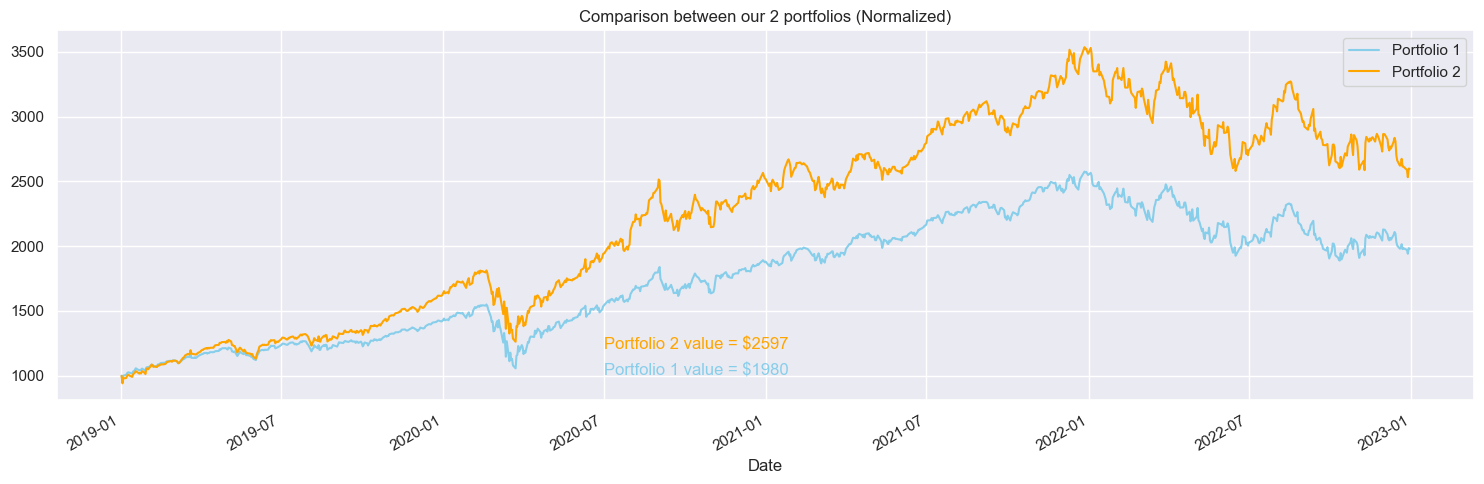

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
port_val1.plot(ax=ax, color='skyblue')
port_val2.plot(ax=ax, color='orange')
plt.legend(['Portfolio 1', 'Portfolio 2'])
plt.title('Comparison between our 2 portfolios (Normalized)')
plt.text('2020-07', 1000, 'Portfolio 1 value = ${:.0f}'.format(port_val1[-1]), color='skyblue')
plt.text('2020-07', 1200, 'Portfolio 2 value = ${:.0f}'.format(port_val2[-1]), color='orange')
plt.tight_layout()

confirming the above result, we can see here the Sharpe Ratio of Portfolio 2 is higher than portfolio 1

-------------------------------------------

# CANDLES CHART

### So interesting! :-)

In [73]:
mpf.available_styles()

['binance',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'yahoo']

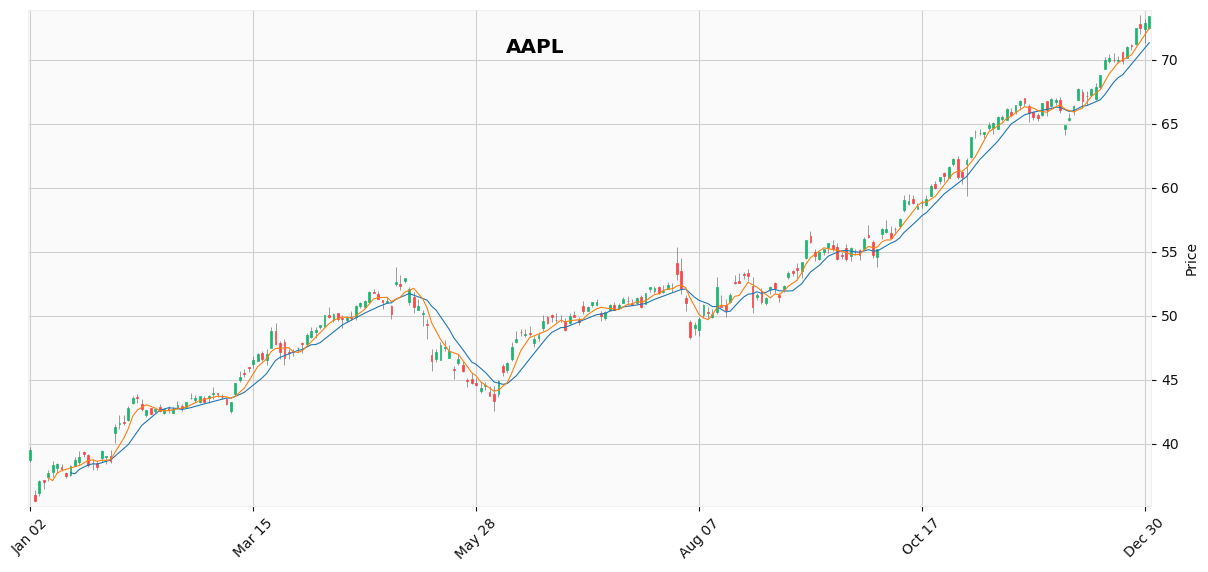

In [258]:
df_aapl = pd.read_csv('AAPL.csv', index_col=0, parse_dates=True)
mask = (df_aapl.index >= '2019-01-01') & (df_aapl.index <= '2019-12-31')
df_aapl = df_aapl.loc[mask]
mpf.plot(df_aapl, type='candle', volume=False, mav=(10,5), title='AAPL', tight_layout=True, figratio=(18,8), style='yahoo')